# Demo Accessing ERDDAP Grid & Table Datasets

This is a demo of accessing `griddap` and `tabledap`
datasets from the SalishSeaCast ERDDAP server
(https://salishsea.eos.ubc.ca/erddap/).

In [1]:
%matplotlib inline

In [2]:
import cmocean
import pandas
import xarray

## About ERDDAP

The SalishSeaCast ERDDAP server (https://salishsea.eos.ubc.ca/erddap/)
is one of a growing herd of ERDDAP servers around the world;
see the **Easier Access to Scientific Data** section on its front page
for information and links about the ERDDAP project,
and https://coastwatch.pfeg.noaa.gov/erddap/download/setup.html#organizations
for a list of many of the ERDDAP instances.

ERDDAP provides [2 types of datasets](https://coastwatch.pfeg.noaa.gov/erddap/download/setupDatasetsXml.html#datasetTypes):
* `griddap` for gridded data such as model results fields
* `tabledap` for tabular data field-deploy instruments like CTDs, ADCPs, buoys, etc.
It also has a special-case of the tablular dataset type that allows it to provide a
virtual file system interface to facilitate downloading files.

Datasets are accessible via a web app interface that provides some basic data visualization capabilities,
and file downloads in various formats of hyperslabs from the datasets.
They are also accessible via a RESTful web service interface.

Key features of ERDDAP is that:
* It provides rich metadata for the datasets.
  That metadata is generally richer and more complete than the metadata contained in the underlying files
  (depending on how committed to good metadata the particular ERDDAP's administrators are :-)
* It abstracts away the storage details of the underlying files.
  Users don't have to know about how to slice or concatenate a dataset's files in order to get
  a 43 day long time series of variable values at a particular depth in a sub-region of a model domain.

The SalishSeaCast ERDDAP serves results from Susan Allen's UBC-MOAD group Salish Sea domain NEMO model,
and Johannes Gemmrich's uVic/IOS Strait of Georgia domain WaveWatch III® model as `griddap` datasets
(https://salishsea.eos.ubc.ca/erddap/griddap/).
It serves results from Michael Dunphy's IOS Vancouver Harbour and Fraser River FVCOM domain model,
and the Strait of Georgia domain WaveWatch III® model via the virtual file system interface
(https://salishsea.eos.ubc.ca/erddap/files/).
A small selection of aggregated datasets from Ocean Networks Canada real-time instruments,
and an IOS horizontal ADCP are served at `tabledap` datasets
(https://salishsea.eos.ubc.ca/erddap/tabledap/).
Links on the `griddap` and `tabledap` pages connect to the `data` request,
`graph` visualization,
and `M`etadata views for each of the datasets
(and the `files` views for the virtual file system interface).

## `griddap` Datasets

While you can use the OPeNDAP protocol to request hyperslabs from datasets
in various file formats the Python `netCDF4` and `xarray` package provide higher level
interfaces with lazy loading.

The code below uses `xarray`.
To make the `%%time` measurements a little more consistent
I've used a context manager to open the dataset in each cell.
Of course that only limits client-side carry-over from one cell to another
and doesn't get rid caching that the ERDDAP server does.

`xarray` and `netCDF4` both access `griddap` datasets using a URL of the form:

    server-address/griddap/dataset-id
    
An easy way to get the correct URL is to take the URL of the dataset's
[data access page](https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12.html)
and drop the `.html` from the end.

Opening the dataset is quite fast because it just loads metadata:

In [3]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    print(ds)

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 43968)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T00:30:00 ... 2020-01-12T23:30:00
  * depth        (depth) float32 0.5000003 1.5000031 ... 414.5341 441.4661
  * gridY        (gridY) int16 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
Data variables:
    salinity     (time, depth, gridY, gridX) float32 ...
    temperature  (time, depth, gridY, gridX) float32 ...
Attributes:
    acknowledgement:           MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    comment:                   If you use this dataset in your research,\nple...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             sallen@eoas.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    creator_url:               https://salishsea-meopar-docs.readthedocs.io/
    description: 

Specifying a hyperslab from the dataset does not trigger data access:

In [4]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    salinity = ds.salinity.isel(depth=0).sel(time="2020-01-09 12:30")

CPU times: user 41.7 ms, sys: 4.94 ms, total: 46.6 ms
Wall time: 130 ms


Data is accessed only when it is operated on:

CPU times: user 115 ms, sys: 11.6 ms, total: 127 ms
Wall time: 628 ms


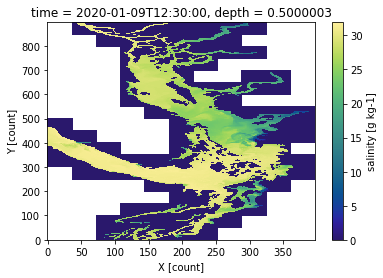

In [5]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity.isel(depth=0).sel(time="2020-01-09 12:30")
         .plot(cmap=cmocean.cm.haline))

Or when it is loaded explicitly:

In [6]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    salinity = ds.salinity.isel(depth=0).sel(time="2020-01-09 12:30").load()

CPU times: user 69.2 ms, sys: 9.16 ms, total: 78.3 ms
Wall time: 588 ms


### Depth Layers

Focussing here on depth layer (i.e. horizontal slice) hyperslabs,
and switching to use the `.sel(..., method="nearest")` method
to avoid having to be too explicit depth and time.

CPU times: user 210 ms, sys: 35.3 ms, total: 245 ms
Wall time: 759 ms


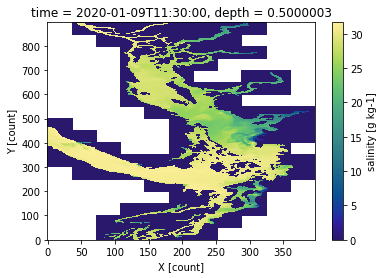

In [7]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity.sel(depth=0, time="2020-01-09 11:00", method="nearest")
         .plot(cmap=cmocean.cm.haline))

There are at least 2 really ugly issues with the renderings above:
1. The dataset coordinates on the horizontal plane are the x/y grid indices,
   not longitude/latitude.
   What is more,
   the dataset *does not even include longitude/latitude* as variables.
2. The coastline is an odd, blocky mixture of `NaN`s (white)
   and zero salinity (dark blue).
   
The second is the easier to deal with.
* The white `NaN`s are due to the land processor elmination that is used in the
  SalishSeaCast NEMO runs to avoid spending computational effort in MPI sub-domains
  that contain no water.
* The dark blue zero salinity "fringe" is the land in the MPI sub-domains that
  contain both land and water.
Both of those artifacts can be eliminated by masking the salinity field with
the appropriate field from the model mesh mask.

The mesh mask is stored in 2 datasets on the SalishSeaCast ERDDAP server:
* https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02
* https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02

It is split like that because one of ERDDAP's rules is that all of the variables
in a dataset must have the same shape.
So, the 2D mesh mask dataset contains NEMO mesh mask variables with coordinates
`(t, y, x)`,
and the 3D dataset contains variables with coordinates `(t, z, y, x)`.
The inclusion of a rather pointless `t` coordinate in the mesh mask variables
is a NEMO idiosyncrasy.

For salinity, we use the `tmask` variable from the 3D mesh mask dataset.
Its values are 0/1 integer flags indicating whether the T-grid point is land/water.

CPU times: user 306 ms, sys: 26 ms, total: 332 ms
Wall time: 944 ms


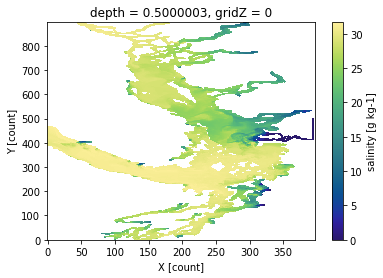

In [8]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02") as mesh:
    with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
        depth=0
        salinity = ds.salinity.sel(depth=depth, time="2020-01-09 11:00", method="nearest")
        mask = mesh.tmask.isel(time=0).sel(gridZ=depth, method="nearest")
        salinity.where(mask).plot(cmap=cmocean.cm.haline)

The solution to the longitude/latitude issue is to use the SalishSeaCast NEMO
model grid geo-reference dataset https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02.
It provides 2D `longitude` and `latitude` variables with `(gridY, gridX)` coordinates.
Since those are the same coordinates as our salinity depth layer has,
we can construct a new `xarray.DataArray` from the masked salinity values
and the longitude/latitude coordinate that we want to plot them on.

CPU times: user 374 ms, sys: 64.5 ms, total: 438 ms
Wall time: 1.36 s


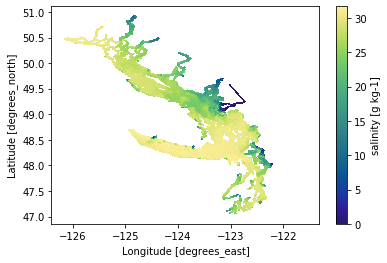

In [36]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02") as geo:
    with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02") as mesh:
        with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
            depth=0
            salinity = ds.salinity.sel(depth=depth, time="2020-01-09 11:00", method="nearest")
            mask = mesh.tmask.isel(time=0).sel(gridZ=depth, method="nearest")
            geo_salinity = xarray.DataArray(
                salinity.where(mask),
                coords={
                    "longitude": geo.longitude,
                    "latitude": geo.latitude,
                }
            )
            geo_salinity.plot.pcolormesh("longitude", "latitude", cmap=cmocean.cm.haline)

## Time Series

While ERDDAP allows us to ignore the storage details of the underlying files,
knowing that the files are chunked as `(1, 40, 898, 398)`
(which we can learn by looking at the metadata for one of the variables in the dataset),
explains why getting 12 values for a time series at a single point in the domain
takes significantly longer than getting the thousands of values in the depth layers above.

CPU times: user 62.2 ms, sys: 3.69 ms, total: 65.9 ms
Wall time: 3.67 s


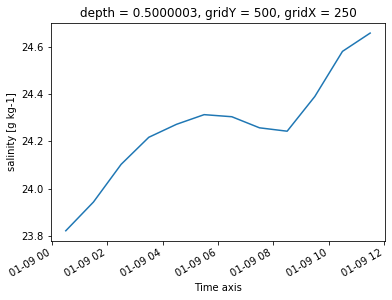

In [9]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
        .sel(depth=0, method="nearest")
        .sel(gridX=250, gridY=500, time=slice("2020-01-09 00:00", "2020-01-09 12:00"))
        .plot())

And knowing that the model results are stored in daily files containing
24 hourly average values means that we shouldn't be surprised that getting
a time series that spans more than one day takes even longer because
ERDDAP has to open more than one underlying file.

CPU times: user 66.3 ms, sys: 4.36 ms, total: 70.6 ms
Wall time: 13 s


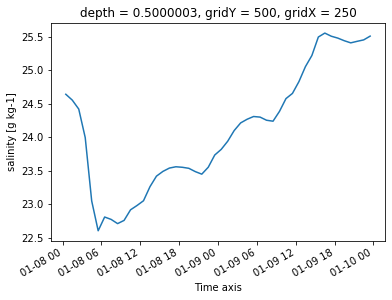

In [10]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(depth=0, method="nearest")
         .sel(gridX=250, gridY=500, time=slice("2020-01-08 00:00", "2020-01-10 00:00"))
         .plot())

### Profiles and Vertical Slices

The `(1, 40, 898, 398)` chunking means that getting the values for
profiles and vertical slices are comparable in speed to getting them for
depth layers.

CPU times: user 230 ms, sys: 11 ms, total: 241 ms
Wall time: 714 ms


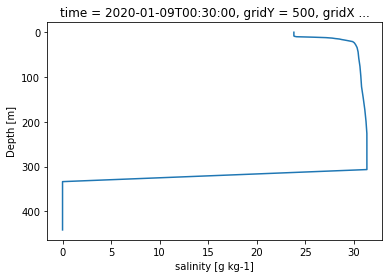

In [11]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(gridX=250, gridY=500, time="2020-01-09 00:00", method="nearest")
         .plot(y="depth", yincrease=False))

CPU times: user 202 ms, sys: 12.8 ms, total: 215 ms
Wall time: 689 ms


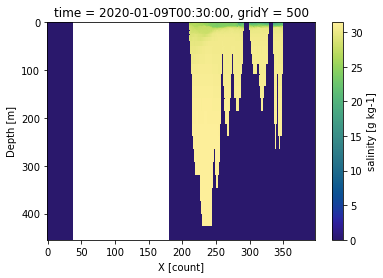

In [12]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
    (ds.salinity
         .sel(gridY=500, time="2020-01-09 00:00", method="nearest")
         .plot(y="depth", yincrease=False, cmap=cmocean.cm.haline))

Unfortunately,
the depth coordinate of the mesh mask dataset is called `gridZ` not `depth`
(as is the case in the 3D tracer fields and other model fields datasets).
That causes problems when we try to mask a profile or vertical slice.
The issue is most easily
(if not elegantly)
resolved by using the underlying `numpy` array of mask values in the `.where()` method;
i.e. `.where(mask.values)`

CPU times: user 268 ms, sys: 2.3 ms, total: 270 ms
Wall time: 832 ms


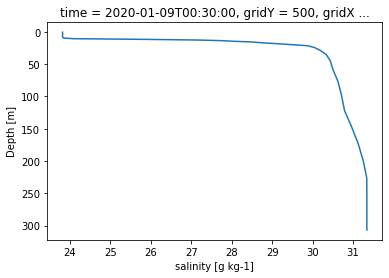

In [13]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02") as mesh:
    with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
        gridX, gridY = 250, 500
        salinity = ds.salinity.sel(gridX=gridX, gridY=gridY, time="2020-01-09 00:00", method="nearest")
        mask = mesh.tmask.isel(time=0).sel(gridX=gridX, gridY=gridY)
        salinity.where(mask.values).plot(y="depth", yincrease=False)

CPU times: user 241 ms, sys: 14.2 ms, total: 255 ms
Wall time: 835 ms


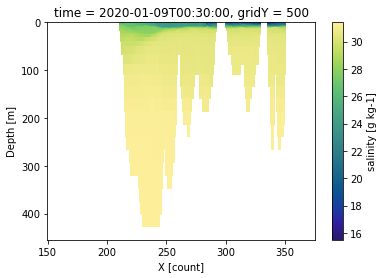

In [14]:
%%time
with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02") as mesh:
    with xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-12") as ds:
        gridX = slice(150, 375)
        gridY = 500
        salinity = ds.salinity.sel(gridX=gridX, gridY=gridY).sel(time="2020-01-09 00:00", method="nearest")
        mask = mesh.tmask.isel(time=0).sel(gridX=gridX, gridY=gridY)
        salinity.where(mask.values).plot(y="depth", yincrease=False, cmap=cmocean.cm.haline)